In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, FunctionTransformer, MinMaxScaler, MaxAbsScaler, PowerTransformer
from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import mean_squared_error

In [ ]:
#train_data = pd.read_csv(r'C:\Users\lscon\Desktop\AA\projeto\the-three-body-problem\mlNOVA\X_train.csv')
train_data = pd.read_csv(r'C:/Users/duart/OneDrive/Ambiente_de_Trabalho/Master_Analysis_Engineering_Big_Data/23-24/1st_semester/AA_ML/Kaggle_challenges/3_body_problem/3_body_problem/X_train.csv')

print(train_data.shape)

### Dropping the velocities

In [ ]:
# Identify faulty rows based on the criterion (all values = 0.0 except for Id)
zero_rows = train_data[(train_data.drop('Id', axis=1) == 0).all(axis=1)]

# Remove the faulty rows from the DataFrame
train_data_preprocessed = train_data[~train_data.index.isin(zero_rows.index)]
train_data_preprocessed.reset_index(drop=True, inplace=True)
#train_data_preprocessed.to_csv('train_preprocessed.csv', index=False)

### Basic stats of the initial matrix

In [ ]:
#gives the stats for the preprocessed data (without the rows with zeros)
summary_stats_filtered = train_data_preprocessed.describe(include='all')

#gives the stats for the nonprocessed data
summary_stats = train_data.describe(include="all")

## Creating the features-labels matrix

In [ ]:
#create feature label matrices
#we're not going to use the velocity components as features
train_data_without_velocity = train_data_preprocessed.drop(columns=['Id','v_x_1','v_x_2','v_y_1', 
                                                           'v_y_2', 'v_x_3', 'v_y_3'])
#divide by simulations
list_of_times = [values for values in train_data_without_velocity['t']]
time_index_tuples = list(enumerate(list_of_times))
zeros_indexes = list(filter(lambda value: value[1] == 0, time_index_tuples))
zeros_indexes = [value[0] for value in zeros_indexes] 
list_of_simulations = []
lower_bound = 0
for i in range(len(zeros_indexes)-1):
    simulation = train_data_without_velocity.iloc[lower_bound:zeros_indexes[i+1]]
    list_of_simulations.append(simulation)
    lower_bound = zeros_indexes[i+1]
from tqdm import tqdm

#add label and put the starting position at every row
#x1
for simulation in tqdm(list_of_simulations):
    first_row_values = simulation.head(1)
    simulation.loc[:,'x_1_label'] = simulation.loc[:, 'x_1']
    simulation.loc[:,'y_1_label'] = simulation.loc[:, 'y_1']
    simulation.loc[:,'x_2_label'] = simulation.loc[:, 'x_2']
    simulation.loc[:,'y_2_label'] = simulation.loc[:, 'y_2']
    simulation.loc[:,'x_3_label'] = simulation.loc[:, 'x_3']
    simulation.loc[:,'y_3_label'] = simulation.loc[:, 'y_3']
    for index, row in simulation.iterrows():
        simulation.at[index, 'x_1'] = first_row_values['x_1']
        simulation.at[index, 'y_1'] = first_row_values['y_1']
        simulation.at[index, 'x_2'] = first_row_values['x_2']
        simulation.at[index, 'y_2'] = first_row_values['y_2']
        simulation.at[index, 'x_3'] = first_row_values['x_3']
        simulation.at[index, 'y_3'] = first_row_values['y_3']

list_of_simulations_copy = list_of_simulations.copy()
random.shuffle(list_of_simulations_copy) #we shuffle the data here so we are only shuffling different simulations and not amongst them
all_simulations = pd.concat(list_of_simulations_copy, ignore_index=True)
all_simulations.to_csv('feature_matrix.csv', index=False)


### Load Feature Matrix

In [4]:
#load the feature matrix file
total_data = np.genfromtxt('feature_matrix.csv', delimiter=',')
total_data = total_data[1:] 


### Train-Vali-Test Split - Pay attention to splitting we are doing, as it will depend on the model we want to use for each way of predicting

In [18]:
#splitting the dataset into training and validation
#sample, lixo = train_test_split(total_data, train_size=0.7, shuffle=False)
data_train, data_temp = train_test_split(total_data, train_size=0.99, shuffle=False)
data_vali, data_test = train_test_split(data_temp, test_size=0.5, shuffle=False)


#### Splitting Features and Labels

In [19]:
#split the labels from the features
features_train = data_train[:, :7]  
labels_train = data_train[:, 7:] 

features_vali = data_vali[:, :7]  
labels_vali = data_vali[:, 7:] 

features_test = data_test[:, :7]  
labels_test = data_test[:, 7:]

### Acceleration function - calculates and appends them to the feature matrix

In [20]:
def accel_proxy(X):
    c1 = X[:, [1,2]]
    c2 = X[:, [3,4]]
    c3 = X[:, [5,6]]

    def _acc(c1, c2):
        c = c1-c2
        return c/(np.linalg.norm(c)**3)

    a1 = _acc(c1, c2) + _acc(c1, c3)
    a2 = _acc(c2, c1) + _acc(c2, c3)
    a3 = _acc(c3, c1) + _acc(c3, c2)
    #a_net = a1 + a2 + a3  # net acceleration of the system?
    
    # Calculate the norm of a_net for each sample (magnitude of the system's acceleration?)
    #a_net_norm = np.linalg.norm(a_net, axis=1, keepdims=True)

    X = np.hstack((X, a1, a2, a3))
    #X = np.hstack((X, a_net_norm))

    return X

accel_transformer = FunctionTransformer(func=accel_proxy)


#### Run just to create a correlation matrix and a pairwise plot of the feature matrix with acceleration (OTHERWISE DON'T)

In [21]:
features_train_transformed = accel_transformer.transform(features_train)


In [23]:
trainaccel = pd.DataFrame(data=features_train_transformed, columns=['t', 'x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'a_x1', 'a_y1', 'a_x2', 'a_y2', 'a_x3','a_y3'])
#trainaccel.to_csv('trainwithaccel.csv', index=False)

In [24]:
# Calculate the correlation matrix and plot it as a heatmap
corr_matrix = trainaccel.corr()

plt.figure(figsize=(20, 16), dpi=800)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.4f',
            linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.savefig('Corr_matrix_heatmap.jpg', dpi=800)
plt.show()


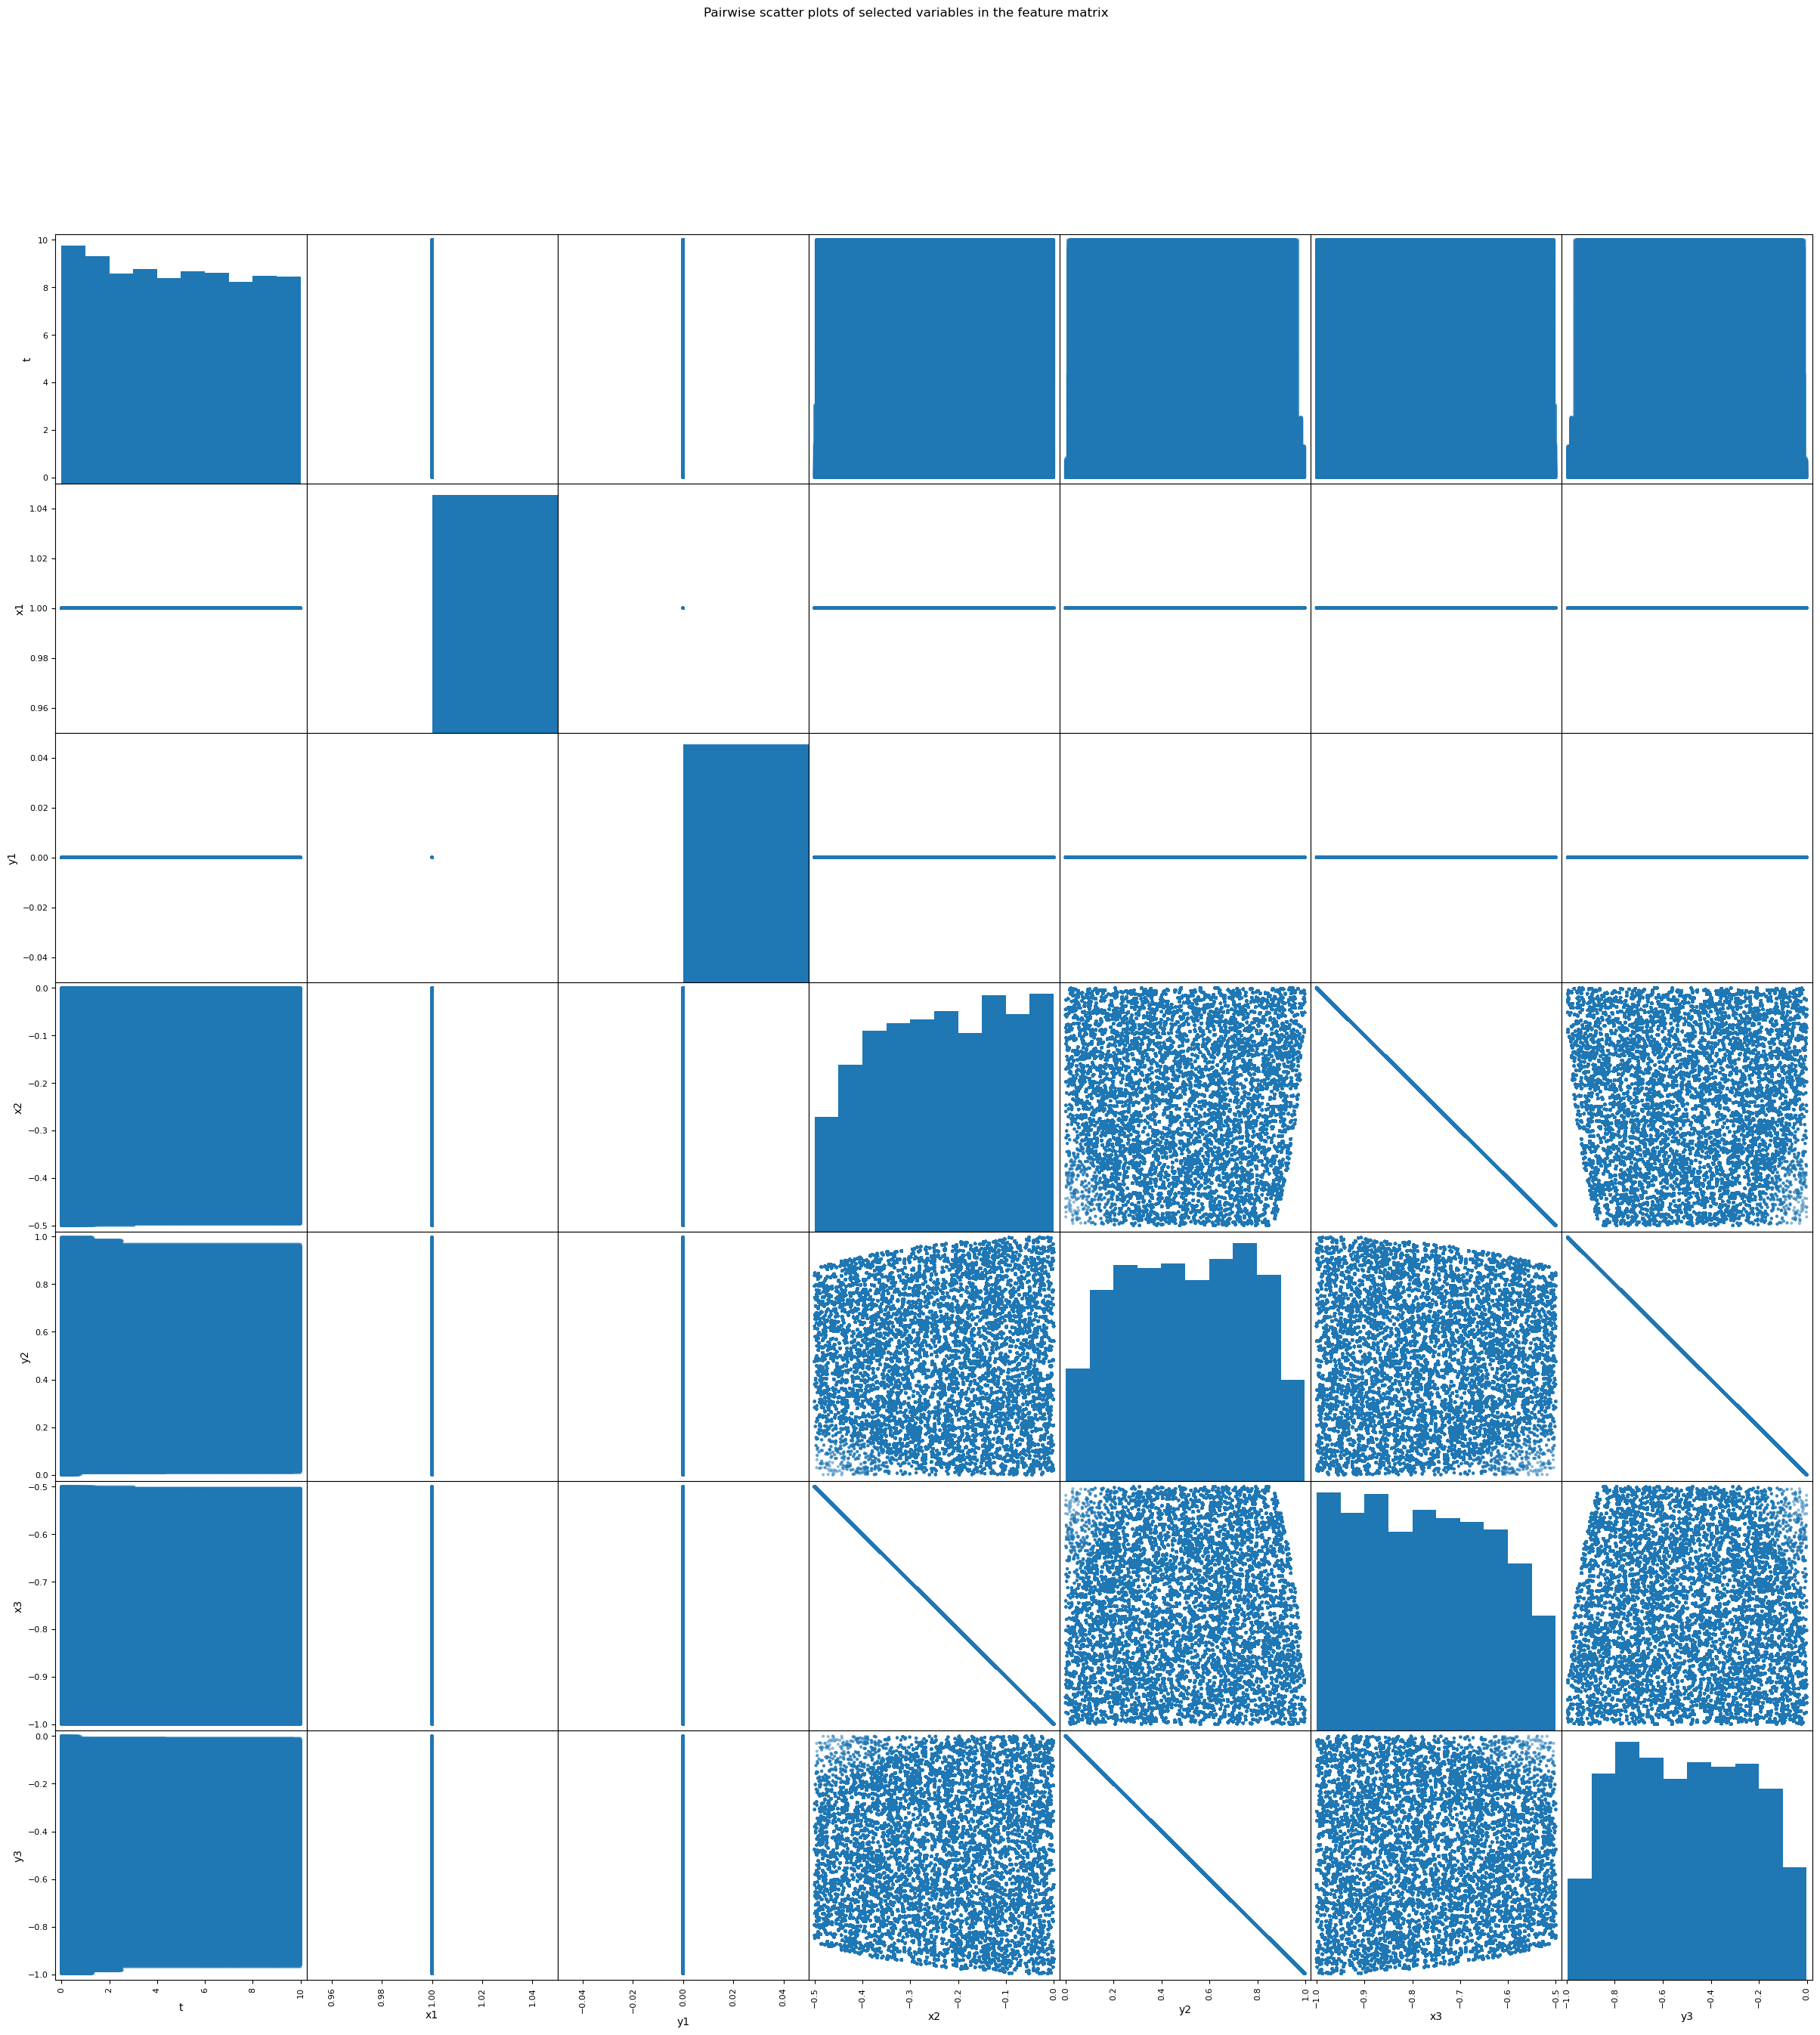

In [31]:
# Select columns 0 to 6 from the trainaccel matrix
selected_columns = trainaccel.iloc[:, 0:7]

# Create a pairwise scatter plot matrix
scatter_matrix = pd.plotting.scatter_matrix(selected_columns, figsize=(30, 30))

plt.suptitle('Pairwise scatter plots of selected variables in the feature matrix')
plt.show()


In [26]:
#gives the stats for the feature matrix with acceleration
summary_stats_feat_matrix = trainaccel.describe(include='all')
summary_stats_feat_matrix = pd.DataFrame(data=summary_stats_feat_matrix)
summary_stats_feat_matrix

,t,x1,y1,x2,y2,x3,y3,a_x1,a_y1,a_x2,a_y2,a_x3,a_y3
count,1.078637e+06,1078637.0,1078637.0,1.078637e+06,1.078637e+06,1.078637e+06,1.078637e+06,1.078637e+06,1.078637e+06,1.078637e+06,1.078637e+06,1.078637e+06,1.078637e+06
mean,4.888040e+00,1.0,0.0,-2.298068e-01,5.008769e-01,-7.701932e-01,-5.008769e-01,6.809202e-10,-1.086268e-10,-2.067709e-10,6.036683e-10,-4.741493e-10,-4.950414e-10
std,2.918989e+00,0.0,0.0,1.379141e-01,2.588977e-01,1.379141e-01,2.588977e-01,2.990989e-11,5.614800e-11,1.662172e-10,3.120294e-10,1.363073e-10,2.558814e-10
min,0.000000e+00,1.0,0.0,-4.999808e-01,2.708792e-04,-9.999512e-01,-9.962189e-01,6.310918e-10,-2.160533e-10,-5.323908e-10,3.264698e-13,-7.012304e-10,-9.846125e-10
25%,2.343750e+00,1.0,0.0,-3.448795e-01,2.831819e-01,-8.892012e-01,-7.234678e-01,6.551105e-10,-1.569009e-10,-3.454592e-10,3.412972e-10,-5.917708e-10,-7.150390e-10
50%,4.843750e+00,1.0,0.0,-2.253519e-01,5.029346e-01,-7.746481e-01,-5.029346e-01,6.799540e-10,-1.090731e-10,-2.014017e-10,6.061482e-10,-4.785523e-10,-4.970751e-10
75%,7.421880e+00,1.0,0.0,-1.107988e-01,7.234678e-01,-6.551205e-01,-2.831819e-01,7.058764e-10,-6.141459e-11,-6.333975e-11,8.719399e-10,-3.604172e-10,-2.798826e-10
max,1.000000e+01,1.0,0.0,-4.883172e-05,9.962189e-01,-5.000192e-01,-2.708792e-04,7.395137e-10,-5.874648e-14,7.013864e-11,1.200666e-09,-2.071229e-10,-2.677234e-13


### Vanilla model with Ridge Regression - removing unnecessary variables (positions of body 1 and 3)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge

# Create a pipeline object
vanilla = Pipeline([
    ('column_transformer', ColumnTransformer([
        ("pw_transf", PowerTransformer(method='yeo-johnson'), [3, 4]),
        ("std_scaler", StandardScaler(), [0])
    ], remainder='drop')),
    ('polynomial_features', PolynomialFeatures(18)),
    ('regressor', Ridge(0.001))
])

vanilla.fit(features_train,labels_train)

labels_pred_train = vanilla.predict(features_train)

mse_train = mean_squared_error(labels_train, labels_pred_train, squared=False)
print(f"RMSE Train:\t{mse_train}")

# Make predictions on the validation data using the best model
labels_pred_vali = vanilla.predict(features_vali)

# Evaluate the performance of the best model on the validation data
mse_vali = mean_squared_error(labels_vali, labels_pred_vali, squared=False)
print(f"RMSE Vali:\t{mse_vali}")

# Make predictions on the test data using the best model
labels_pred_test = vanilla.predict(features_test)

# Evaluate the performance of the best model on the test data
mse_test = mean_squared_error(labels_test, labels_pred_test, squared=False)
print(f"RMSE Test:\t{mse_test}")


### Learning Feature Engineering - Model w/accelerations in the pipeline and Ridge Regression (acceleration seems to decrease model performance compared to just positions of body 2 and time - SEE CORRELATION MATRIX AS TO WHY)

In [19]:
reg_accel = Pipeline([
    ('acceleration_transformer', accel_transformer),
    ('column_transformer', ColumnTransformer([
        ("std_scaler", StandardScaler(), [0, 7]),
        ("pwr_scaler", PowerTransformer(method='yeo-johnson'), [3, 4]),
    ], remainder='drop')),
    ('polynomial_features', PolynomialFeatures(12)),
    ('regressor', Ridge(10)),
])

# Fit the pipeline using features_train and labels_train
reg_accel.fit(features_train, labels_train)

labels_pred_train = reg_accel.predict(features_train)

mse_train = mean_squared_error(labels_train, labels_pred_train, squared=False)
print(f"RMSE Train:\t{mse_train}")

# Make predictions on the validation data using the best model
labels_pred_vali = reg_accel.predict(features_vali)

# Evaluate the performance of the best model on the validation data
mse_vali = mean_squared_error(labels_vali, labels_pred_vali, squared=False)
print(f"RMSE Vali:\t{mse_vali}")

# Make predictions on the test data using the best model
labels_pred_test = reg_accel.predict(features_test)

# Evaluate the performance of the best model on the test data
mse_test = mean_squared_error(labels_test, labels_pred_test, squared=False)
print(f"RMSE Test:\t{mse_test}")


RMSE Train:	1.1842053505993588
RMSE Vali:	1.12065445484404
RMSE Test:	1.0681386287376804


### LAZY LEARNING - Using K Nearest Neighbours Regression - acceleration does not seem to affect our models performance (See correlation matrix) - Always choose K value with gridsearch beforehand

In [15]:
knn_reg = Pipeline([
    #('acceleration_transformer', accel_transformer),
    ('column_transformer', ColumnTransformer([
        ("std_scaler", StandardScaler(), [0]),
        ("pwr_scaler", PowerTransformer(method='yeo-johnson'), [3, 4]),
    ], remainder='drop')),
    ('knn_reg', KNeighborsRegressor(33)),
    ])

# Fit the pipeline using features_train and labels_train
knn_reg.fit(features_train, labels_train)

labels_pred_train = knn_reg.predict(features_train)

mse_train = mean_squared_error(labels_train, labels_pred_train, squared=False)
print(f"RMSE Train:\t{mse_train}")

# Make predictions on the validation data using the best model
labels_pred_vali = knn_reg.predict(features_vali)

# Evaluate the performance of the best model on the validation data
mse_vali = mean_squared_error(labels_vali, labels_pred_vali, squared=False)
print(f"RMSE Vali:\t{mse_vali}")

# Make predictions on the test data using the best model
labels_pred_test = knn_reg.predict(features_test)

# Evaluate the performance of the best model on the test data
mse_test = mean_squared_error(labels_test, labels_pred_test, squared=False)
print(f"RMSE Test:\t{mse_test}")

RMSE Train:	0.6115135416254748
RMSE Vali:	1.3653533534270645
RMSE Test:	2.025901181035182


### GridSearch Best K Value - then plug that value in the above model

In [14]:
# Define K values to be tested
k_values = [29, 31, 33, 35, 37, 39] 
    # Start with some values; If the highest one is picked, erase the smaller ones, plug in higher values and keep trying until the best K value is somewhere in the middle of the tested values

# Parameter grid for GridSearch
param_grid = {'knn_reg__n_neighbors': k_values}

# Search Time!
grid_search = GridSearchCV(knn_reg, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)  # using all cores in parallel with n_jobs = -1; we use negative so that the smaller (i.e. less negative, is picked)

# Fit training data
grid_search.fit(features_train, labels_train)

# Best parameters and corresponding RMSE
print("Best Parameters:", grid_search.best_params_)
print("Best RMSE:", np.sqrt(-grid_search.best_score_))

# Extract the best model - we can run this directly or plug above to see what the model is actually doing (more visual)
best_knn_reg = grid_search.best_estimator_

Best Parameters: {'knn_reg__n_neighbors': 49}
Best RMSE: 2.1884668539553402


### REAL WORLD DATA PREDICTIONS

In [13]:
X_realworld = pd.read_csv(r'C:/Users/duart/OneDrive/Ambiente_de_Trabalho/Master_Analysis_Engineering_Big_Data/23-24/1st_semester/AA_ML/Kaggle_challenges/3_body_problem/3_body_problem/X_test.csv')
id_column = X_realworld['Id']
print(id_column.head())
X_realworld.drop('Id', axis=1, inplace=True)
X_realworld.to_csv('X_realworld.csv', index=False)

0    0
1    1
2    2
3    3
4    4
Name: Id, dtype: int64


## Creating predictions file - Choose the adequate model pipeline name from the models above

In [14]:
# Make predictions on the preprocessed real-world data
X_realworld = pd.read_csv('X_realworld.csv')
X_realworld = X_realworld.to_numpy()
predictions_realworld = knn_reg.predict(X_realworld)


# Create a new Pandas DataFrame with the predictions
df_predictions = pd.DataFrame(predictions_realworld)
df_predictions.insert(loc=0, column='Id', value = id_column)
df_predictions.columns=['Id', 'x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3']

# Submit the Pandas DataFrame to the challenge creator
df_predictions.to_csv('predictions.csv', index=False)   # change the name (either here directly or in the actual file so we know which model, with which parameters created each set of predictions - and describe them when plugging it on kaggle)